# <u>M</u>edical <u>D</u>eep <u>L</u>earning
## Exercise 1: 3D Semantic Segmentation

(please see Moodle for dates / times for presence exercises and hand-in requirements) 

![3D Segmentation](https://cloud.imi.uni-luebeck.de/s/mJ934RgeNttTeYb/download)

The objective of this exercise is to guide you step-by-step through the implementation of a deep 3D-CNN for multi-organ segmentation. We will be using the Learn2Reg Abdominal CT dataset with 20 training and 10 validation scans each manually labelled with 13 organs.

The exercise is split into two basic tasks and one bonus task. First you will implement and train a standard fully-convolutional network that directly predicts the probability of each class on a coarse grid and uses a simple upsampling to match the original resolution. Second you will extend the network to learn more abstract ("deeper") features and implement two classifiers (low and high), one of them with a squeeze-and-excitation module.

The bonus task will focus on reducing the model complexity by replacing standard convolutions with inverted residuals from MobileNet.

In [ ]:
#import the necessary toolboxes and check whether CUDA is available
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import numpy
import numpy as np
import nibabel as nib
from torchsummary import summary

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'


tensor_cores_available = False
if(torch.cuda.is_available()==False):
    print('CUDA not found! It is highly recommended to enable CUDA for this exercise')
else:
    print('CUDA GPU found: ',torch.cuda.get_device_name(['0']))
    if torch.cuda.get_device_capability('cuda')[0] >= 7:
        tensor_cores_available = True
        print('Turing/Ampere with TensorCores is available, you can speed up training with FP16 precision')

CUDA GPU found:  Tesla P100-PCIE-16GB


In [ ]:
#download data and visualise an example ground truth segmentation
if(not(os.path.exists('L2R_Task3_AbdominalCT.tar'))):
    !wget https://cloud.imi.uni-luebeck.de/s/ijcNnYg2yFPqpZr/download -O L2R_Task3_AbdominalCT.tar
!wget https://cloud.imi.uni-luebeck.de/s/TALoqagyYeqQFs4/download -O abdomen_labels.txt
!tar -xf L2R_Task3_AbdominalCT.tar

--2022-04-20 11:44:42--  https://cloud.imi.uni-luebeck.de/s/ijcNnYg2yFPqpZr/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 674498560 (643M) [application/x-tar]
Saving to: ‘L2R_Task3_AbdominalCT.tar’

L2R_Task3_Abdominal 100%[===================>] 643.25M  62.0MB/s    in 15s     

2022-04-20 11:44:58 (41.9 MB/s) - ‘L2R_Task3_AbdominalCT.tar’ saved [674498560/674498560]

--2022-04-20 11:44:58--  https://cloud.imi.uni-luebeck.de/s/TALoqagyYeqQFs4/download
Resolving cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)... 141.83.20.118
Connecting to cloud.imi.uni-luebeck.de (cloud.imi.uni-luebeck.de)|141.83.20.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1270 (1.2K) [text/plain]
Saving to: ‘abdomen_labels.txt’

abdomen_labels.txt  100%[===================>]   1.24K  -

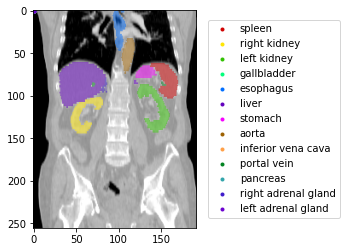

In [ ]:
#select one scan as validation case
nu = 26
img_val = torch.from_numpy(nib.load('Training/img/img00'+str(nu).zfill(2)+'.nii.gz').get_fdata()).float()
img_val = img_val.permute(2,1,0)
gt_val = torch.from_numpy(nib.load('Training/label/label00'+str(nu).zfill(2)+'.nii.gz').get_fdata()).float()
gt_val = gt_val.permute(2,1,0)
H,W,D = img_val.shape

### overlaySegment: returns RGB-overlay of given image and segmentation
def overlaySegment(gray1,segs1,colors):
    H, W = segs1.squeeze().size()
    C = colors.shape[0] 
    segs1_onehot = torch.zeros(size=(C,H,W)).to(segs1.device).scatter_(0, segs1.view(1,H,W), 1).detach()
    seg_color = torch.mm(segs1_onehot.view(C,-1).t(),colors).view(H,W,3)
    alpha = torch.clamp(1.0 - 0.5*(segs1_onehot[0,:,:]==0).float(),0,1.0)
    overlay = (gray1*alpha).unsqueeze(2) + seg_color*(1.0-alpha).unsqueeze(2)
    return overlay
cdata = torch.from_numpy(np.loadtxt('abdomen_labels.txt',skiprows=14,usecols=(1,2,3))).float()
organs = np.genfromtxt('abdomen_labels.txt',dtype='str',delimiter='"',skip_header=14,usecols=(1,))
rgb = overlaySegment(torch.clamp(img_val.flip(0).squeeze()[:,70]+800,0,1200)/1200,gt_val.flip(0).long().squeeze()[:,70],cdata.view(-1,3)/255)
plt.imshow(rgb)
for i in range(1,14):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs[i])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

In [ ]:
#provided functions for normalising CT scans, calculating Dice overlaps and counting trainable parameter of a model
def nnUNetCTnorm(img):
    img = torch.clamp(img, -1000, 1500)
    mean_intensity = img.mean()
    std_intensity = img.std()
    lower_bound = torch.quantile(img,0.005)
    upper_bound = torch.quantile(img,0.995)
    img = torch.clamp(img, lower_bound, upper_bound)
    img = (img - mean_intensity) / std_intensity
    return img
img_norm_val = nnUNetCTnorm(img_val.unsqueeze(0).unsqueeze(0).cuda())


def dice_coeff(outputs, labels, max_label):
    dice = torch.FloatTensor(max_label-1).fill_(0)
    for label_num in range(1, max_label):
        iflat = (outputs==label_num).view(-1).float()
        tflat = (labels==label_num).view(-1).float()
        intersection = torch.mean(iflat * tflat)
        dice[label_num-1] = (2. * intersection) / (1e-8 + torch.mean(iflat) + torch.mean(tflat))
    return dice

def countParameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params

In [ ]:
#next we prepare the training data and store everything in a dataset
#dataset Learn2Reg AbdomenCTCT with 13 organs

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
#from tqdm import tqdm
from tqdm.notebook import tqdm, trange


class Learn2Reg_AbdomenCT(Dataset):
    def __init__(self, train=True):
        self.train = train
        if(train):
            cases = (2,3,5,6,8,9,21,22,24,25,27,28,30,31,33,34,36,37,39,40)
        else:
            cases = (1,4,7,10,23,26,29,32,35,38)
        self.img_norm = torch.zeros(len(cases),1,256,160,192)
        self.gt_label = torch.zeros(len(cases),256,160,192, dtype=torch.long)
        for i,nu in enumerate(tqdm(cases)):
            img = torch.from_numpy(nib.load('Training/img/img00'+str(nu).zfill(2)+'.nii.gz').get_fdata()).float()
            img = img.permute(2,1,0)
            gt = torch.from_numpy(nib.load('Training/label/label00'+str(nu).zfill(2)+'.nii.gz').get_fdata()).long()
            gt = gt.permute(2,1,0)
            img_norm = nnUNetCTnorm(img.unsqueeze(0).unsqueeze(0).cuda()).cpu().squeeze()
            self.img_norm[i,0] = img_norm
            self.gt_label[i] = gt
    
    def __len__(self):
        return int(self.img_norm.shape[0])

    def __getitem__(self, idx):
        image = self.img_norm[idx:idx+1]
        label = self.gt_label[idx:idx+1]
        
        return image.squeeze(0), label.squeeze(0)

#create instances of dataset and training dataloader
train_dataset = Learn2Reg_AbdomenCT(train=True)
train_dataloader = DataLoader(train_dataset, batch_size=3, shuffle=True, pin_memory=True)

train_img, train_label = next(iter(train_dataloader))
print('Shapes of each img/label tensor pair',train_img.shape,train_label.shape)

  0%|          | 0/20 [00:00<?, ?it/s]

Shapes of each img/label tensor pair torch.Size([3, 1, 256, 160, 192]) torch.Size([3, 256, 160, 192])


### Task 1a: Affine transformation

Due to the lack of training data in our dataset and thus the high risk of overfitting during training, we want to create synthetic data by using small random affine transformations.

Therefor, we use `F.grid_sample` that takes a grid (flow field) with world coordinates and samples the values from the input for the specified position. Read the [pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.grid_sample.html) for a detailed explanation.

Let's create a grid with `F.affine_grid`. Therefor, we need a random transformation matrix `theta` of shape $[B, 3, 4]$, where $B$ describes the batch size. Create `theta` using `torch.eye` and add a random offset via `torch.randn` to it. The offset should be weighted with 0.05 (Hint: to obtain the needed shape use broadcasting with `.unsqueeze(0)` on the eye matrix). Next, we use `theta` to create the flow filed with `F.affine_grid` with the image shape as target output size.

Now, we just sample from our image and ground truth via `F.grid_sample` with `padding_mode=border`. Use `mode=bilinear` for the image and `mode=nearest` for the ground truth. We also have to consider the datatype of `ground_truth` and add a channel dimension to it with `unsqueeze(1)`.

If you like, you can also perform the augmentation on the GPU (do not forget `with torch.no_grad()`).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'affine transformation')

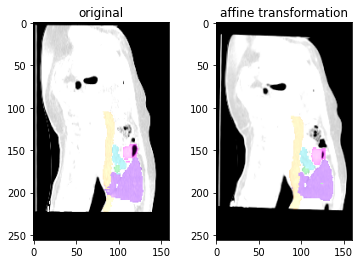

In [ ]:
from nibabel.volumeutils import shape_zoom_affine
def augment_affine(image: torch.Tensor, ground_truth: torch.Tensor):
    batch_size = image.shape[0]
    # todo, implement the affine transformation
    theta = torch.eye(3, 4).unsqueeze(0) + 0.05*torch.randn(batch_size, 3, 4)
    grid = F.affine_grid(theta=theta, size=image.shape)
    image = F.grid_sample(image, grid, padding_mode="border", mode="bilinear")
    ground_truth = F.grid_sample(ground_truth.unsqueeze(1).to(torch.float), grid, padding_mode="border", mode="nearest")
    ground_truth = ground_truth.to(torch.long)

    # need to be fulfilled
    assert image.dtype == torch.float
    assert ground_truth.dtype == torch.long
    assert list(image.shape) == [batch_size, 1, 256, 160, 192]
    assert list(ground_truth.shape) == [batch_size, 1, 256, 160, 192]
    
    return image, ground_truth.squeeze()

# provided function to visualize augmentation
img, gt = train_dataset[0]
idx = 95

fig, axs = plt.subplots(1, 2)
rgb = overlaySegment(img.squeeze()[:, :, idx], gt[:, :, idx].long() ,cdata.view(-1,3)/255)
axs[0].imshow(rgb)
axs[0].set_title('original')

img, gt = augment_affine(img.unsqueeze(0), gt.unsqueeze(0))
rgb_aug = overlaySegment(img.squeeze()[:, :, idx].cpu(), gt[:, :, idx].cpu() ,cdata.view(-1,3)/255)
axs[1].imshow(rgb_aug)
axs[1].set_title('affine transformation')

### Task 1b: Preparation and definition of a Fully-convolutional Network (FCN) for segmentation

The different organs in 3D medical images are very different in size, while the liver has a volume of 1.5-2 litres (and several hundred thousands of voxels) the adrenial glands are only of a few millilitres with a few thousands voxels. We therefore need to weigh the loss with inverse frequency to improve the training stability. You can use ```torch.bincount``` [pytorch-doc](https://pytorch.org/docs/stable/generated/torch.bincount.html) on a 1D vector (of long datatype) that you can obtain from ```train_dataset.gt_label```. Convert the count into a float vector and use a reciprocal power of 0.35 to obtain a **weight** vector. Divide this vector by its mean - it should look as follows:
```0.0873, 0.5060, 0.6909, 0.6879, 1.2039, 1.5785, ...```

In [ ]:
#TODO weighted CE-Loss 
gt_label = train_dataset.gt_label # 1D vector (of long datatype) that you can obtain from train_dataset.gt_label
gt_label_1d = gt_label.view(-1)
count = torch.bincount(gt_label_1d.to(torch.long)).to(torch.float)
weight = torch.pow(count, -0.35) # use reciprocal power of 0.35
weight = weight/torch.mean(weight) # tourch.mean(weight)
weight

tensor([0.0873, 0.5060, 0.6909, 0.6879, 1.2039, 1.5785, 0.2965, 0.4819, 0.8316,
        0.8406, 1.1448, 0.8602, 2.4897, 2.3003])

Next, we build our fully-convolutional network `fullyconv` that directly predicts the probability of each class on a coarse grid and uses a simple upsampling to match the original resolution. Therefor, we need a `nn.Sequential` container that holds four ConvGroups. Each group consists of 
1. a `nn.Conv3d` with kernel size = 3, padding = 1 and no bias
1. a `nn.InstanceNorm3d` for normalisation
1. a `nn.LeakyReLU` as non-linearity

The first ConvGroup should increase the channel dimension to 16 and reduce the spatial dimension with a stride=2 in the `nn.Conv3d`. The second group should double the channels and again reduce the spatial dimension using the same stride as group one. The third and fourth group have an output channel dimension=64 and keep the spatial resolution (no stride).

We use a single `nn.Conv3d` with same kernel and padding properties like the one of the ConvGroup, but this time with the bias enabled, as classifier (output channel should match the number of classes=14).

In [ ]:
# for reproducibility
torch.manual_seed(42)

fullyconv = nn.Sequential(
    #TODO implement backbone
    nn.Conv3d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm3d(16),
    nn.LeakyReLU(),
    
    nn.Conv3d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=False),
    nn.InstanceNorm3d(32),
    nn.LeakyReLU(),

    nn.Conv3d(in_channels=32, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.InstanceNorm3d(64),
    nn.LeakyReLU(),

    nn.Conv3d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False),
    nn.InstanceNorm3d(64),
    nn.LeakyReLU(),

    # the classifier layer
    nn.Conv3d(in_channels=64, out_channels=14, kernel_size=3, padding=1, bias=True)
)
print('#fullyconv',countParameters(fullyconv))

fullyconv.cuda()
summary(fullyconv, (1,256, 160, 192))

#fullyconv 204350
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 16, 128, 80, 96]             432
    InstanceNorm3d-2      [-1, 16, 128, 80, 96]               0
         LeakyReLU-3      [-1, 16, 128, 80, 96]               0
            Conv3d-4       [-1, 32, 64, 40, 48]          13,824
    InstanceNorm3d-5       [-1, 32, 64, 40, 48]               0
         LeakyReLU-6       [-1, 32, 64, 40, 48]               0
            Conv3d-7       [-1, 64, 64, 40, 48]          55,296
    InstanceNorm3d-8       [-1, 64, 64, 40, 48]               0
         LeakyReLU-9       [-1, 64, 64, 40, 48]               0
           Conv3d-10       [-1, 64, 64, 40, 48]         110,592
   InstanceNorm3d-11       [-1, 64, 64, 40, 48]               0
        LeakyReLU-12       [-1, 64, 64, 40, 48]               0
           Conv3d-13       [-1, 14, 64, 40, 48]          24,206
Total params: 204,350

### Task 1c: Training the FCN for segmentation

**Implement your training loop**, you can use a helper function that performs forward and backward pass, does an update step on the optimizer and returns the current loss. Refer to [torch.optim](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step) to see an example of this loop in pytorch.
In case you want to explore accelerated FP16 training have a look at [cuda.amp.autocast](https://pytorch.org/docs/stable/notes/amp_examples.html).

In each of 500 iterations, employing ```next(iter(train_dataloader))``` yields a pair training images and labels (mini-batch size = 3). Augment this data with your `augment_affine` function. Make sure to upsample the prediction to the correct output shape (same size as your target) using ```F.interpolate``` [pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html) and pass the **weight** tensor to ```nn.CrossEntropyLoss```[pytorch-doc](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

The training takes several minutes on the GPU and should result in an average validation Dice of approx. 50%


In [ ]:
def train(input,target,model,weight,optimizer,scaler):
    H,W,D = target.shape[-3:]
    with torch.cuda.amp.autocast(enabled=tensor_cores_available):
        # todo, forward, interpolation, loss calculation
        optimizer.zero_grad()
        output = F.interpolate(model(input),size=(H,W,D),mode='trilinear',align_corners=False)
        c = nn.CrossEntropyLoss(weight.to(device))
        loss = c(output, target) #?????????????? how to use loss function and pass the weight tensor
    
    # todo, backward pass
    loss.backward()
    optimizer.step()

    return loss.item()

#we have provided a function that quantifies the accuracy for a single validation scan
def validate(model):
    model.eval()
    with torch.no_grad():
        input = img_norm_val.cuda()
        output = F.interpolate(model(input),size=(H,W,D),mode='trilinear',align_corners=False)
    model.train()
    d2 = dice_coeff(gt_val.contiguous().cuda(),output.argmax(1).squeeze().contiguous().cuda(),14).cpu()
    return d2,output
    

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


iter: 49, loss: 0.446, Dice: 1.303, runtime: 144.524 sec
iter: 99, loss: 0.722, Dice: 15.067, runtime: 287.121 sec
iter: 149, loss: 0.425, Dice: 23.187, runtime: 429.429 sec
iter: 199, loss: 0.372, Dice: 34.553, runtime: 575.124 sec
iter: 249, loss: 0.253, Dice: 33.493, runtime: 718.180 sec
iter: 299, loss: 0.236, Dice: 47.626, runtime: 866.261 sec
iter: 349, loss: 0.204, Dice: 49.337, runtime: 1010.980 sec
iter: 399, loss: 0.277, Dice: 48.607, runtime: 1155.931 sec
iter: 449, loss: 0.210, Dice: 47.707, runtime: 1300.433 sec
iter: 499, loss: 0.159, Dice: 52.503, runtime: 1443.198 sec


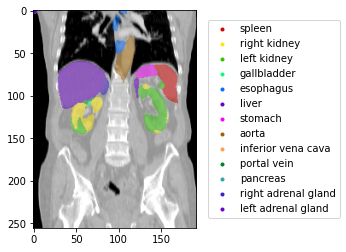

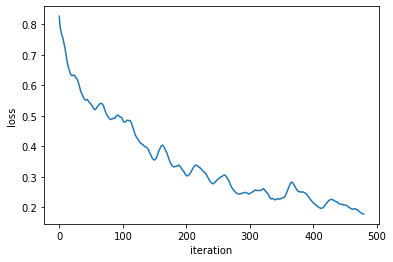

In [ ]:
fullyconv.cuda()
optimizer = torch.optim.Adam(list(fullyconv.parameters()),lr=0.001)
scaler = torch.cuda.amp.GradScaler()
run_loss = torch.zeros(500)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in trange(500):
    
    #todo, get data, augment them, call train()
    
    # get data
    train_img, train_label = next(iter(train_dataloader))
    
    # augment them
    train_img, train_label = augment_affine(train_img, train_label)

    train_img = train_img.to(device)
    train_label = train_label.to(device)
    # call train()
    loss_item = train(input=train_img, target=train_label, model=fullyconv, weight=weight, optimizer=optimizer, scaler=scaler)
    run_loss[i] = loss_item
    
    if(i%50==49):
        d2,val_output = validate(fullyconv)
        str1 = f"iter: {i}, loss: {'%0.3f'%loss_item}, Dice: {'%0.3f'%(100*d2.mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec"
        tqdm.write(str1)
        
        # housekeeping
        torch.cuda.empty_cache()

# we have provided a function that visualises the outcome on an unseen scan after the training has finished 
rgb = overlaySegment(torch.clamp(img_val.flip(0).squeeze().cpu()[:,70]+800,0,1200)/1200,val_output.argmax(1).squeeze().cpu().contiguous().flip(0).long().squeeze()[:,70],cdata.view(-1,3)/255)
plt.imshow(rgb)
for i in range(1,14):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs[i])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

plt.plot(F.avg_pool1d(F.avg_pool1d(run_loss.view(1,1,-1),11,stride=1),11,stride=1).squeeze())
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# housekeeping
torch.cuda.empty_cache()

### Task 2: Segmentation using LR-ASPP
We can see that this simple model produces only moderately accurate segmentations. We therefore want to implement an advanced segmentation network known as **lite reduced atrous spatial pyramid pooling (LR-ASPP)** [Paper: Searching for MobileNet V3](https://arxiv.org/pdf/1905.02244v1.pdf), which basically consists of two classifiers: one with a high number of channel and low spatial resolution and one with a lower number of channels and higher spatial resolution.  
![LRASPP_fig](https://github.com/mattiaspaul/binder_test/raw/main/architecture.png)
To achieve this we need another sequential container with `nn.Conv3d`, `nn.InstanceNorm3d` and `nn.ReLU` to obtain the *deeper* features with more channels denoted as **high**. It should take 64 channels as input and double this number twice, while increasing the stride by 2 in the first Conv3d. 

Those features are also used as input for a squeeze-and-exication block (denoted as SAE) that comprises `nn.AdaptiveAvgPool3d` another `nn.Conv3d` (with kernel size=1) and nn.Sigmoid as activation. This produces a global channel weight that is multiplied to the result of the input tensor after a block of Conv3d, BatchNorm3d and ReLU (denoted as CBR). 

Finally, the product has to upsampled by a factor of 2 and the number of channels needs to be projected to 14 output class using a Conv3d (with kernel=1) as classifier HIGH.

For the high-resolution another Conv3d (kernel=3, in_channel=out_channel), BatchNorm3d, ReLU, Conv3d (kernel=1) block will be used that produces 14 output channels (classifier LOW) and both results are simply added.

The training time should remain similar, but the accuracy can be improved to over 65% Dice overlap. (you can reach nearly 70% when running the training for 1000 iterations)

In [ ]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm3d
#todo, implement two sequential containers with 4 and 2 Conv3d-InstanceNorm3d-ReLU blocks each and name them net_low
#(same architecture like 'fullyconv', but without the classifier layer) and net_high
#in the forward function the input is first passed through net_low and its output is inserted into net_high
#implement the CBR And SAE blocks to be used for the 'high' features.  

class LRASPP(nn.Module):
    def __init__(self, high_channels=256, inter_channels=128, low_channels=64, num_classes=14):
        super().__init__()
        self.net_low = nn.Sequential(
            # todo
            nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.InstanceNorm3d(128),
            nn.LeakyReLU()

            #nn.Conv3d(in_channels=128, out_channels=256, kernel_size=3, padding=1, bias=False),
            #nn.InstanceNorm3d(256),
            #nn.LeakyReLU()
            #64
        )
        self.net_high = nn.Sequential(
            # todo
            nn.Conv3d(in_channels=inter_channels, out_channels=high_channels, kernel_size=1, padding=1, bias=False),
            nn.InstanceNorm3d(high_channels),
            nn.LeakyReLU()
            #128
        )
        
        self.CBR = nn.Sequential(
            # todo
            nn.Conv3d(in_channels=high_channels, out_channels=inter_channels, kernel_size=1, padding=1, bias=False),
            nn.InstanceNorm3d(high_channels),
            nn.ReLU()
        )
        self.SAE = nn.Sequential(
            # todo
            nn.AdaptiveAvgPool3d(1),
            nn.Conv3d(in_channels=high_channels, out_channels=14, kernel_size=1, padding=1, bias=True),
            nn.Sigmoid()
        )
        self.LOW = nn.Sequential(
            # todo
            nn.Conv3d(in_channels=inter_channels, out_channels=14, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm3d(14),
            nn.ReLU(),
            nn.Conv3d(in_channels=high_channels, out_channels=14, kernel_size=1, padding=1, bias=True)
        )
        self.HIGH = nn.Sequential(nn.Conv3d(in_channels=high_channels, out_channels=14, kernel_size=1, padding=1, bias=True)) # todo
        
    def forward(self, input):
        # todo        
        output_0 = self.net_low(input)
        output_1 = self.net_high(output_0)

        output_LOW = self.LOW(output_0)
        output_CBR = self.CBR(output_1)
        output_SAE = self.SAE(output_1)
        
        output_2 = output_CBR * output_SAE
        output_3 = F.interpolate(output_SAE, size=output_LOW.shape[-2:], mode="bilinear", align_corners=True)
        output_HIGH = self.HIGH(output_3)
        
        output_semantic_segmentation = output_HIGH + output_LOW

        return
    
lraspp = LRASPP()  
lraspp.cuda()
summary(lraspp, (1,256, 160, 192))

RuntimeError: ignored

In [ ]:
#re-use the same training loop as before
lraspp.cuda()
optimizer = torch.optim.Adam(list(lraspp.parameters()),lr=0.001)
scaler = torch.cuda.amp.GradScaler()
run_loss = torch.zeros(500)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for i in tqdm(range(500)):
    
    #todo, get data, augment them, call train()
    
    # get data
    train_img, train_label = next(iter(train_dataloader))
    
    # augment them
    train_img, train_label = augment_affine(train_img, train_label)

    train_img = train_img.to(device)
    train_label = train_label.to(device)
    # call train()
    loss_item = train(input=train_img, target=train_label, model=fullyconv, weight=weight, optimizer=optimizer, scaler=scaler)
    run_loss[i] = loss_item
    
    if(i%50==49):
        d2,val_output = validate(lraspp)
        str1 = f"iter: {i}, loss: {'%0.3f'%loss_item}, Dice: {'%0.3f'%(100*d2.mean())}, runtime: {'%0.3f'%(time.time()-t0)} sec"
        tqdm.write(str1)
        
        # housekeeping
        torch.cuda.empty_cache()

#we have provided a function that visualises the outcome on an unseen scan after the training has finished 
rgb = overlaySegment(torch.clamp(img_val.flip(0).squeeze().cpu()[:,70]+800,0,1200)/1200,val_output.argmax(1).squeeze().cpu().contiguous().flip(0).long().squeeze()[:,70],cdata.view(-1,3)/255)
plt.imshow(rgb)
for i in range(1,14):
    plt.plot(0,0,'.',color=cdata[i].numpy()/255,label=organs[i])
    plt.legend(bbox_to_anchor=(1.04,.5), loc='center left' )
plt.show()

plt.plot(F.avg_pool1d(F.avg_pool1d(run_loss.view(1,1,-1),11,stride=1),11,stride=1).squeeze())
plt.xlabel('iteration')
plt.ylabel('loss')
plt.show()

# housekeeping
torch.cuda.empty_cache()